In [36]:
#installing libraries
%pip install torch torchvision numpy matplotlib numpy opencv-python opencv-python-headless pinecone-client


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
#importing libraries
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, models, transforms
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
import cv2
from torch.utils.data import Subset
import pinecone


Files already downloaded and verified
Files already downloaded and verified


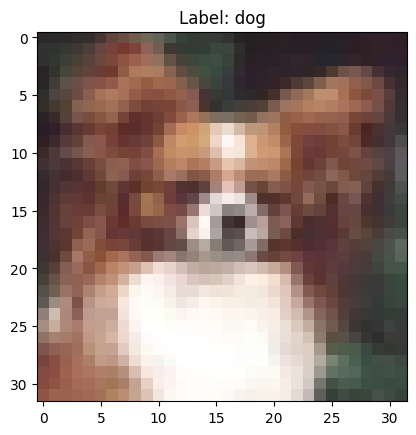

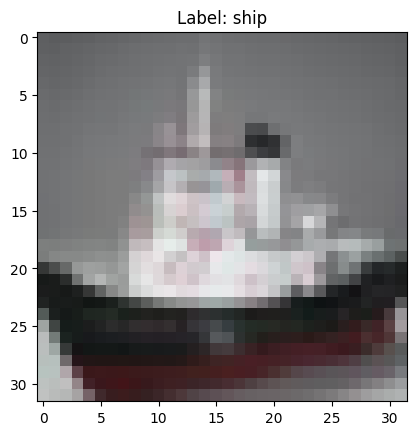

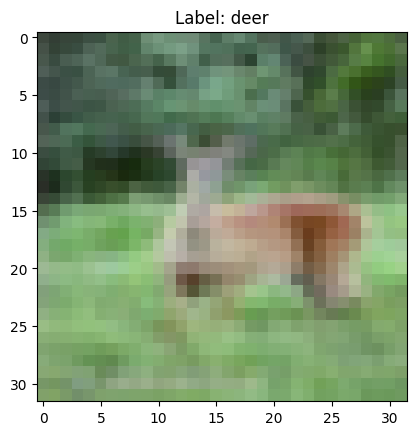

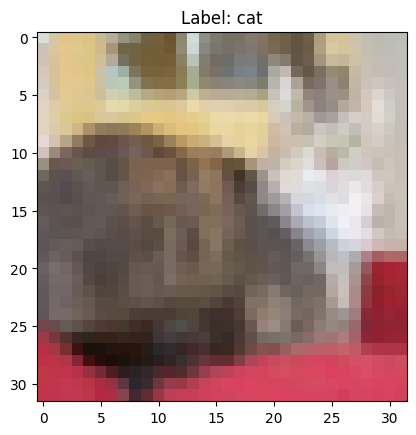

In [6]:
#transformation and normalization of data
transform = transforms.Compose(
    #convert images to pytorch tensors
    [transforms.ToTensor(),
     #normaloze images with mean and std
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#chose CIFAR-10 dataset
#import training dataset using predifined transformations
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

#import testing dataset using same predifined transformations
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

#picture classes in CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#show img with with label
def imshow(img, label):
    #unnormalize img
    img = img / 2 + 0.5
    #convert to numpy array
    npimg = img.numpy()
    #transpose dimensions
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #set title as class label
    plt.title(f"Label: {classes[label]}")
    plt.show()

#get random training images and show with label
dataiter = iter(trainloader)
images, labels = next(dataiter)

for i in range(len(images)):
    imshow(images[i], labels[i])


Number of keypoints: 12
Shape of descriptors: (12, 128)


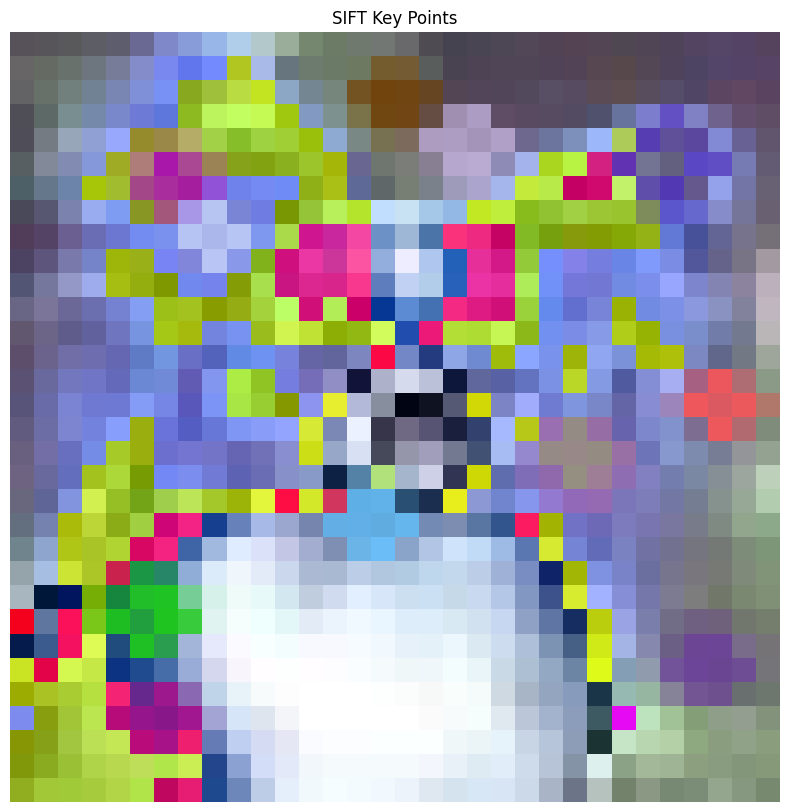

Number of keypoints: 3
Shape of descriptors: (3, 128)


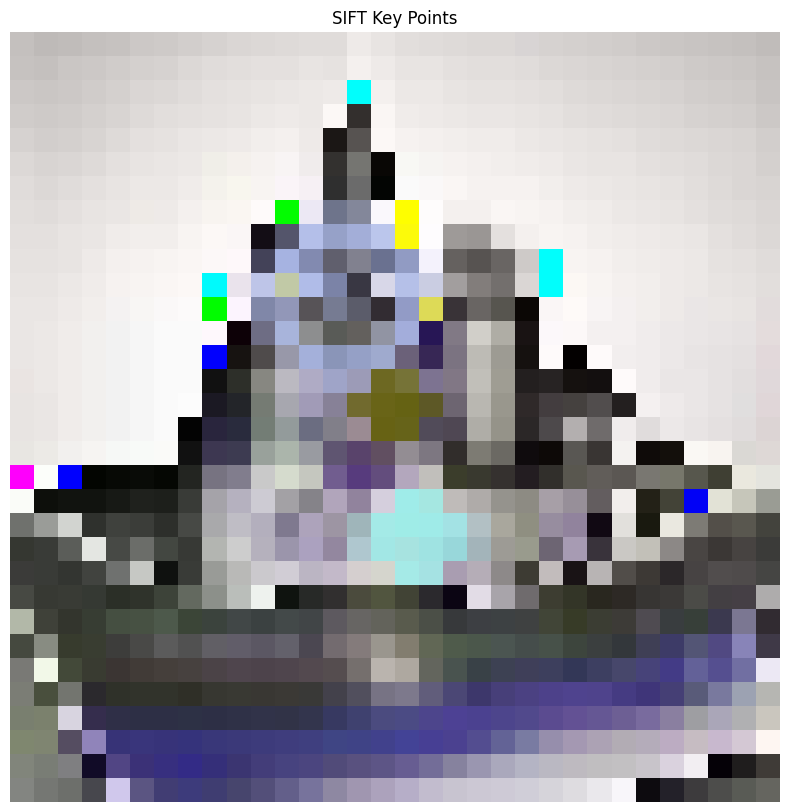

Number of keypoints: 17
Shape of descriptors: (17, 128)


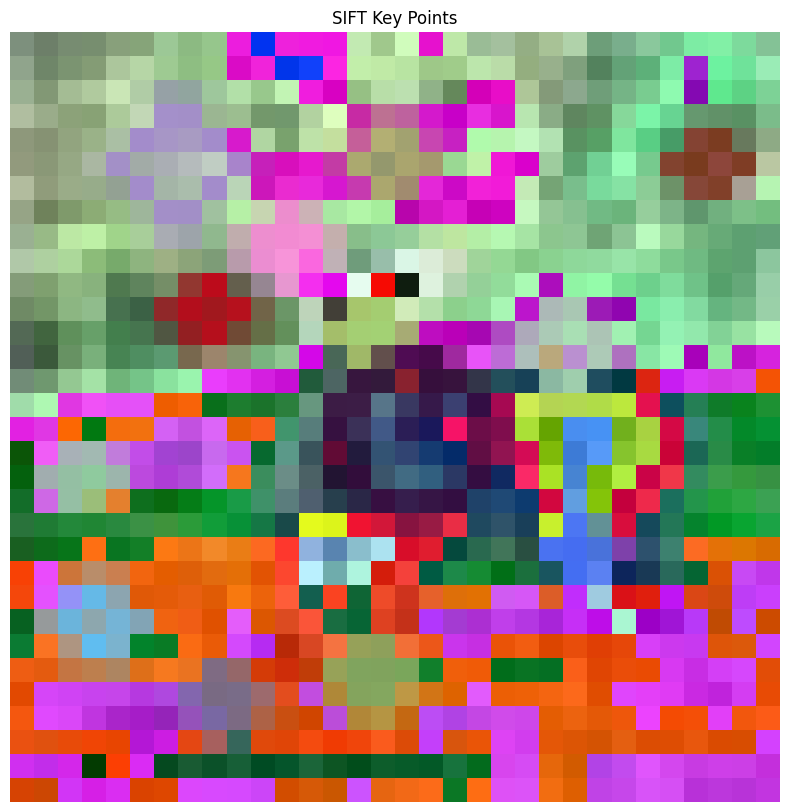

In [13]:
#iterate through the three images gathered in the 'images' array
for i in range(3):
    #convert to numpy array
    image = images[i].numpy()
    #transpose image
    image = np.transpose(image, (1, 2, 0))
    #change the scale of images to 0-255
    image = (image*255).astype(np.uint8)
    #convert to grayscale
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #sift detector
    sift = cv2.SIFT_create()

    #detect key points / compute descriptors
    keypoints, desc = sift.detectAndCompute(grayscale_image, None)

    # Print the number of keypoints and shape of descriptors
    print(f"Number of keypoints: {len(keypoints)}")
    print(f"Shape of descriptors: {desc.shape}")

    #draw keypoints on original img
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    #convert image to RGB for plotting
    image_with_keypoints = cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB)

    #plot the img with key points
    plt.figure(figsize=(10, 10))
    plt.imshow(image_with_keypoints)
    plt.axis('off')
    plt.show()


Feature extraction

c:\Users\bende\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\bende\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Conv layer features shape: torch.Size([1, 512, 2, 2])
Fully connected layer features shape: torch.Size([1, 1000])


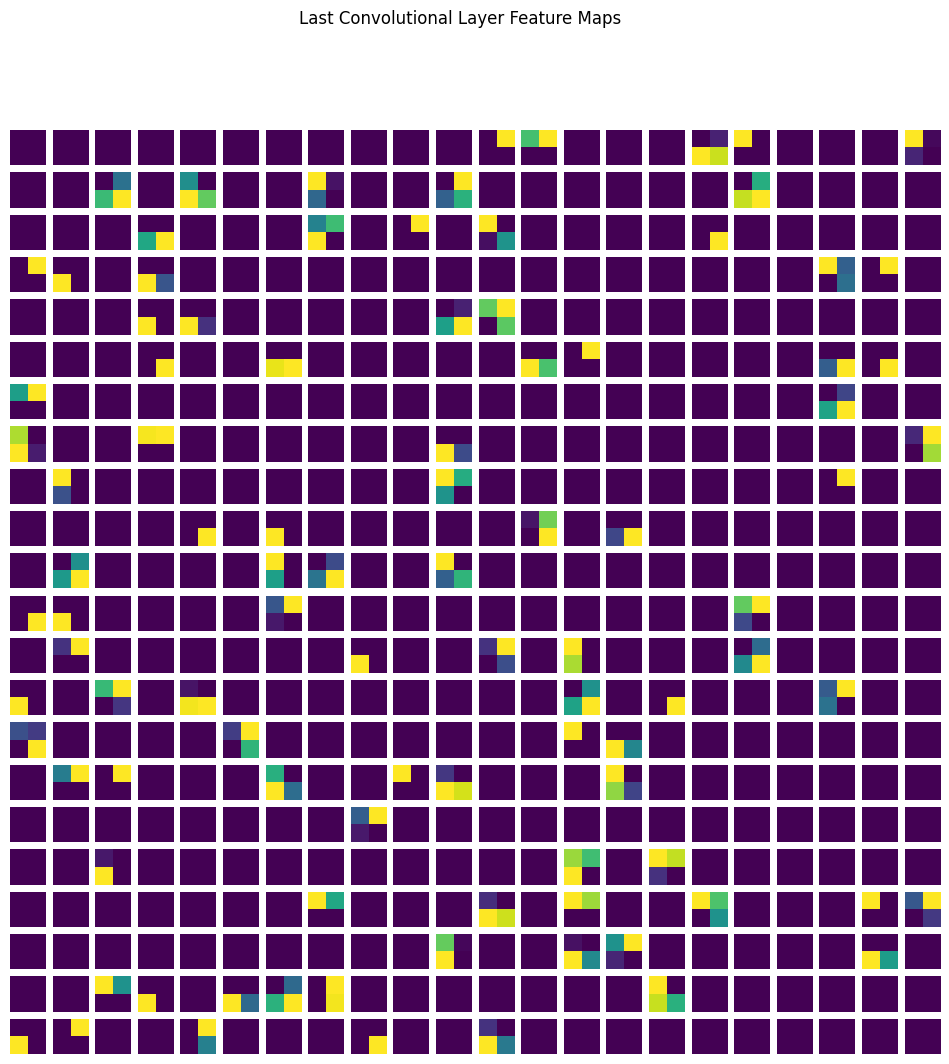

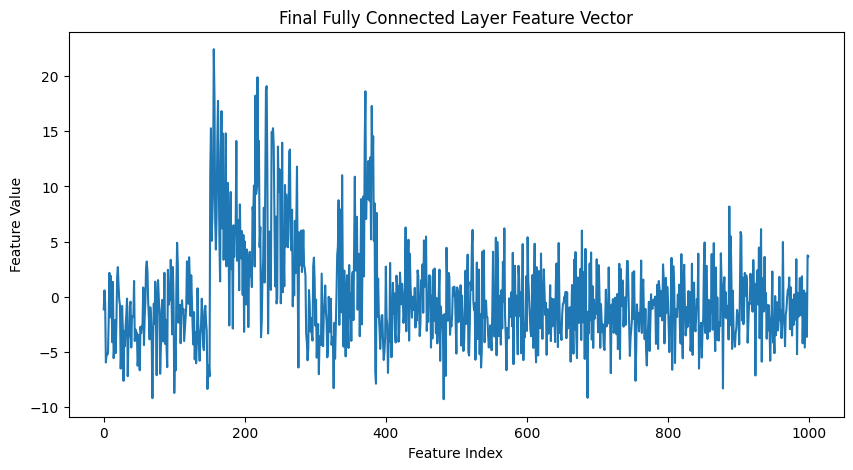

Conv layer features shape: torch.Size([1, 512, 2, 2])
Fully connected layer features shape: torch.Size([1, 1000])


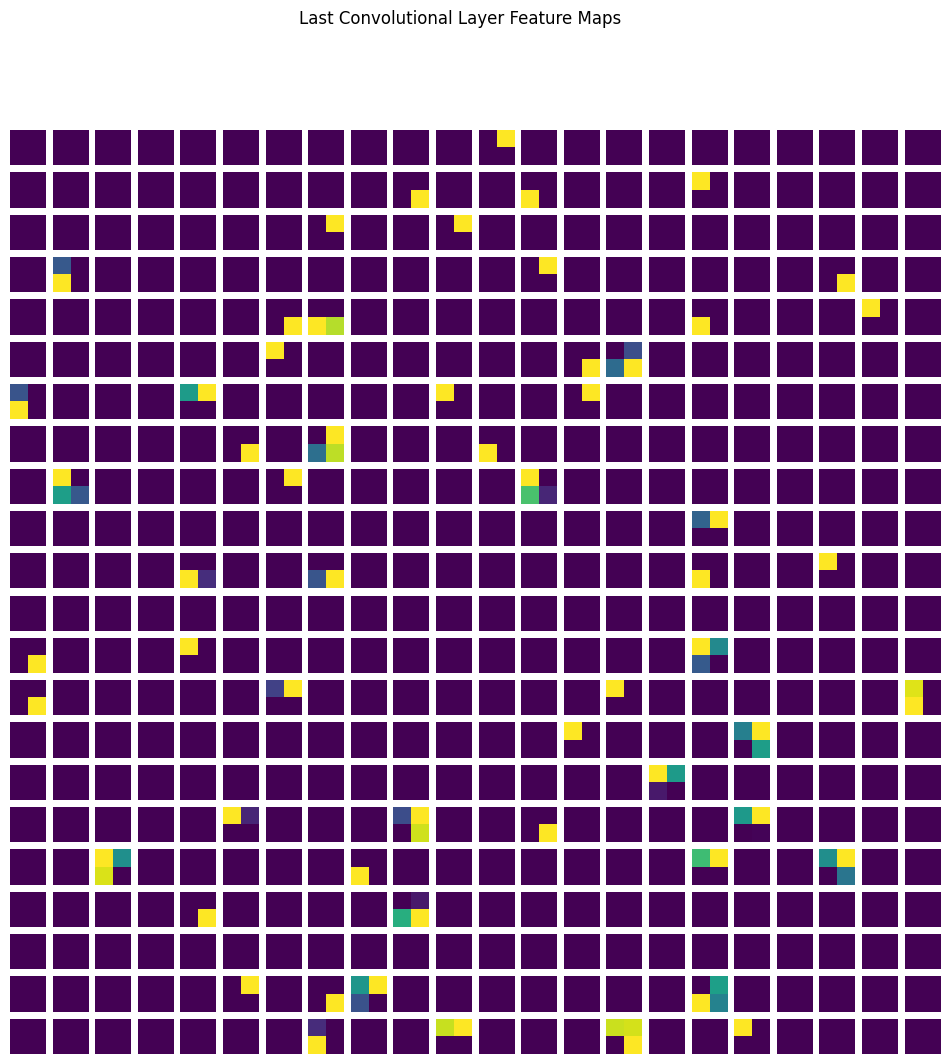

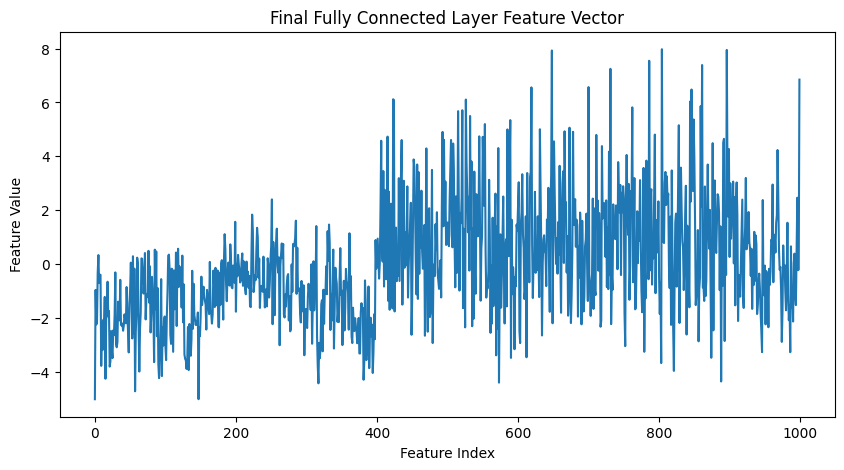

In [16]:
#get pre trained model vgg16
model = models.vgg16(pretrained=True)
model.eval()

#iterate through some images saved in the 'images' array
for i in range(2):
    #get image and add batch dimension
    image = images[i].unsqueeze(0)

    #dict to store features
    features = {}

    #function to get features from specified layer
    def get_features(name):
        def hook(model, input, output):
            #store layer output to features dict
            features[name] = output.detach()
        return hook

    #get features from last convolutional layer
    model.features[29].register_forward_hook(get_features('conv'))
    #get features from last fully connected layer
    model.classifier[6].register_forward_hook(get_features('fc'))

    #forward pass with image and get features
    output = model(image)
    conv_features = features['conv']
    fc_features = features['fc']

    #print feature shapes
    print(f"Conv layer features shape: {conv_features.shape}")
    print(f"Fully connected layer features shape: {fc_features.shape}")

    #visualize feature maps
    def visualize_feature_maps(features, title):
        #remove batch dimension
        features = features.squeeze(0)
        #get number of feature maps
        num_feature_maps = features.shape[0]
        #get size of grid to display features
        size = int(np.sqrt(num_feature_maps))

        #create subplot for feature maps
        _, axes = plt.subplots(size, size, figsize=(12, 12))
        for i, ax in enumerate(axes.flat):
            if i < num_feature_maps:
                ax.imshow(features[i].cpu(), cmap='viridis')
                ax.axis('off')
        plt.suptitle(title)
        plt.show()

    #visualize some last conv layer features
    visualize_feature_maps(conv_features, 'Last Convolutional Layer Feature Maps')

    #visualize the feature vector of fully connected layer
    fc_features = fc_features.cpu().numpy()
    plt.figure(figsize=(10, 5))
    plt.plot(fc_features[0])
    plt.title('Final Fully Connected Layer Feature Vector')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Value')
    plt.show()

Similarity Measures


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Query Image:


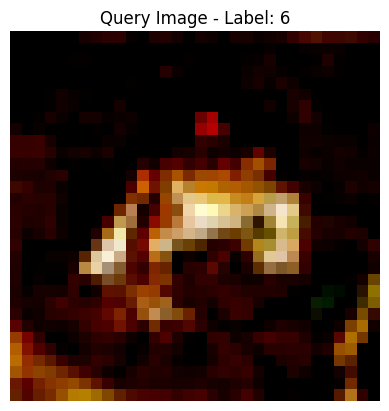

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


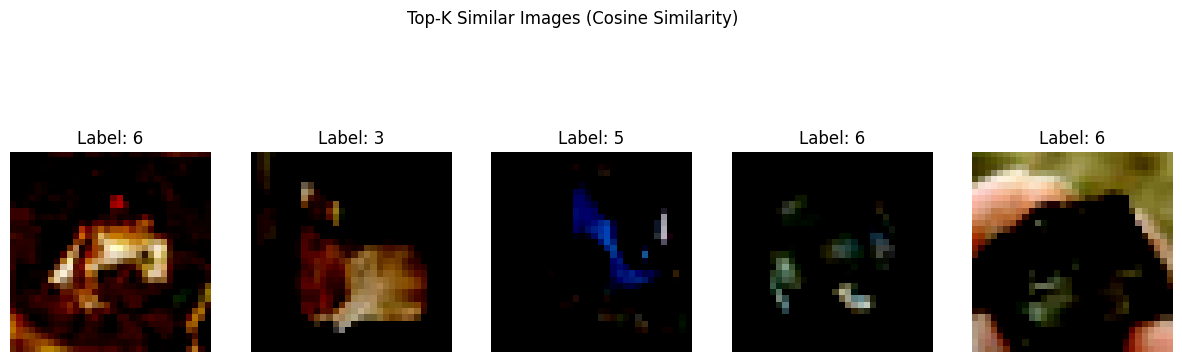

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


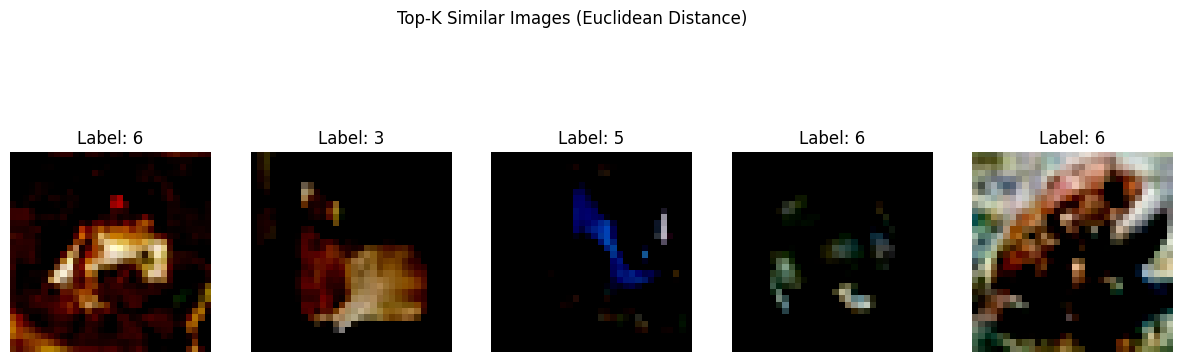

In [44]:
#create a list of ints from 1-300 to use for a subset of images
indices = list(range(300))
#create a subset of the training set of CIFAR-10 using the indices
subset = Subset(trainset, indices)
#load the subset
subset_loader = torch.utils.data.DataLoader(subset, batch_size=1, shuffle=False)

#create empty lists for various features and metadata of the images that should be saved
vector = []
images = []
labels = []

#iterate through created subset and save features and data of images
for i, data in enumerate(subset_loader):
    #get image and label
    inputs, label = data
    #get output features from image
    output = model(inputs)
    #append the output features to the lists
    vector.append(features['fc'].squeeze().numpy())
    images.append(inputs.squeeze().permute(1, 2, 0).numpy())
    labels.append(label.item())

#convert feature vetor to numpy array
feature_vectors = np.array(vector)

#cosine similarity
def cosine_similarity(vec1, vec2):
    #compute dot product of two vectors
    dot_product = np.dot(vec1, vec2)
    #compute norm of both vectors
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    #compute cosine similarity and return
    return dot_product / (norm_vec1 * norm_vec2)

#euclidiean distance
def euclidean_distance(vec1, vec2):
    #return the distance between the two vectors
    return np.linalg.norm(vec1 - vec2)

#retrieve k most similar images
def retrieve_top_k(query_image, feature_vectors, k=5, metric='cosine'):
    if metric == 'cosine':
        #calculate cosine similarities with all images to query image
        similarities = [cosine_similarity(query_image, fv) for fv in feature_vectors]
        #sort in descending order
        sorted_indices = np.argsort(similarities)[::-1]
    elif metric == 'euclidean':
        #calculate euclidian distance between all images and query image
        distances = [euclidean_distance(query_image, fv) for fv in feature_vectors]
        #sort in ascending order
        sorted_indices = np.argsort(distances)

    #return the top k indices of both search metrics
    top_k_indices = sorted_indices[:k]
    return top_k_indices

#choose an image to query with
query_image = feature_vectors[0]

#get top k images using cosine similarity and euclidean distance
top_k_cosine = retrieve_top_k(query_image, feature_vectors, k=5, metric='cosine')
top_k_euclidean = retrieve_top_k(query_image, feature_vectors, k=5, metric='euclidean')

#display the chosen images computed using each metric
def display_images(indices, title):
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 5))
    for ax, idx in zip(axes, indices):
        ax.imshow(images[idx])
        ax.set_title(f"Label: {labels[idx]}")
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

#display query image
print("Query Image:")
plt.imshow(images[0])
plt.title(f"Query Image - Label: {labels[0]}")
plt.axis('off')
plt.show()

#display the top k images for each metric
display_images(top_k_cosine, "Top-K Similar Images (Cosine Similarity)")
display_images(top_k_euclidean, "Top-K Similar Images (Euclidean Distance)")

Image Retrieval Pipeline


In [25]:

def extract_sift_features(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Create a SIFT feature extractor
    sift = cv2.SIFT_create()
    
    # Detect and compute SIFT features
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    # print("keypoint :",keypoints)
    # print("descriptors :",descriptors)
    
    return descriptors

def cluster_features(features, k):
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    
    # Get the cluster centers (visual words)
    visual_words = kmeans.cluster_centers_
    
    return visual_words

In [26]:
# Extract SIFT features from each image in the subset
all_descriptors = []
image_descriptors = []

for i, data in enumerate(subset_loader):
    inputs, _ = data
    # Convert tensor to numpy array and to BGR format for OpenCV
    image = inputs.squeeze().permute(1, 2, 0).numpy()
    image = (image * 255).astype(np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    descriptors = extract_sift_features(image)
    if descriptors is not None:
        all_descriptors.extend(descriptors)
        image_descriptors.append(descriptors)

all_descriptors = np.array(all_descriptors)
print(f"Total descriptors: {all_descriptors.shape}")

Total descriptors: (3388, 128)


In [27]:
# Set the number of clusters (visual words)
k = 100  # You can adjust this number based on your needs

# Cluster the SIFT features
visual_words = cluster_features(all_descriptors, k)
print(f"Visual words shape: {visual_words.shape}")


Visual words shape: (100, 128)


In [28]:
# Function to assign each SIFT feature to the nearest visual word
def assign_visual_words(descriptors, visual_words):
    assignments = []
    for descriptor in descriptors:
        distances = np.linalg.norm(descriptor - visual_words, axis=1)
        nearest_word_id = np.argmin(distances)
        assignments.append(nearest_word_id)
    return assignments

# Represent each image as a list of visual word IDs
image_visual_words = []

for descriptors in image_descriptors:
    words = assign_visual_words(descriptors, visual_words)
    image_visual_words.append(words)

# Display the visual word representation of the first image
print(f"Visual words for the first image: {image_visual_words[0]}")


Visual words for the first image: [80, 41, 3, 57, 36, 6, 52, 20]


In [30]:
#B

# Load and process the query image
query_image = images[0]
query_image = transform(query_image).permute(1, 2, 0).numpy()
query_image = (query_image * 255).astype(np.uint8)
query_image = cv2.cvtColor(query_image, cv2.COLOR_RGB2BGR)

# Extract SIFT features from the query image
query_descriptors = extract_sift_features(query_image)

# Assign each query feature to its nearest visual word in the codebook
query_visual_words = assign_visual_words(query_descriptors, visual_words)

print(f"Visual words for the query image: {query_visual_words}")


Visual words for the query image: [92, 7]


In [31]:
#C

# Initialize the inverted index
inverted_index = {}

# Build the inverted index
for img_idx, words in enumerate(image_visual_words):
    for word in words:
        if word not in inverted_index:
            inverted_index[word] = []
        inverted_index[word].append(img_idx)

# Display the inverted index for the first few visual words
for word_id in list(inverted_index.keys())[:5]:
    print(f"Visual word {word_id}: {inverted_index[word_id]}")


Visual word 80: [0, 8, 8, 18, 21, 23, 24, 35, 47, 49, 58, 81, 89, 93, 135, 165, 166, 171, 178, 182, 202, 232, 293, 295]
Visual word 41: [0, 14, 36, 50, 62, 79, 80, 112, 121, 123, 142, 146, 149, 163, 176, 191, 201, 223, 269, 270, 291]
Visual word 3: [0, 4, 12, 12, 19, 24, 25, 27, 48, 56, 56, 57, 59, 59, 63, 68, 68, 72, 77, 85, 87, 90, 91, 91, 98, 98, 124, 132, 136, 155, 161, 164, 169, 170, 173, 177, 178, 192, 213, 215, 217, 219, 220, 221, 222, 222, 233, 243, 255, 266, 266, 267, 272, 273, 273, 275, 282, 285]
Visual word 57: [0, 5, 14, 36, 48, 65, 65, 72, 73, 88, 90, 99, 102, 117, 135, 139, 151, 165, 187, 189, 194, 212, 214, 227, 229, 241, 243, 250, 251, 265, 272, 279, 281, 287, 294, 297]
Visual word 36: [0, 6, 7, 11, 30, 50, 58, 72, 90, 90, 91, 92, 94, 98, 113, 121, 126, 129, 133, 135, 141, 145, 154, 164, 165, 176, 177, 178, 178, 202, 202, 203, 210, 211, 214, 214, 222, 229, 235, 238, 249, 256, 264, 267, 277, 291, 293, 298]


Visual words for the query image: [15, 37, 71, 48, 55, 46, 36, 50, 14, 88, 85, 83, 14, 37, 94, 49]
Query Image:


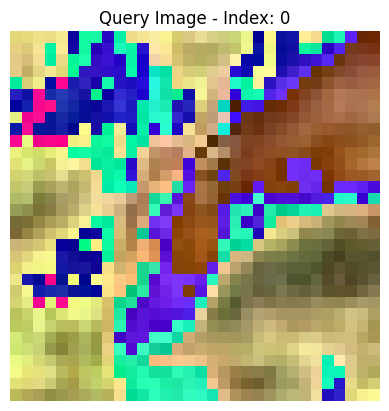

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


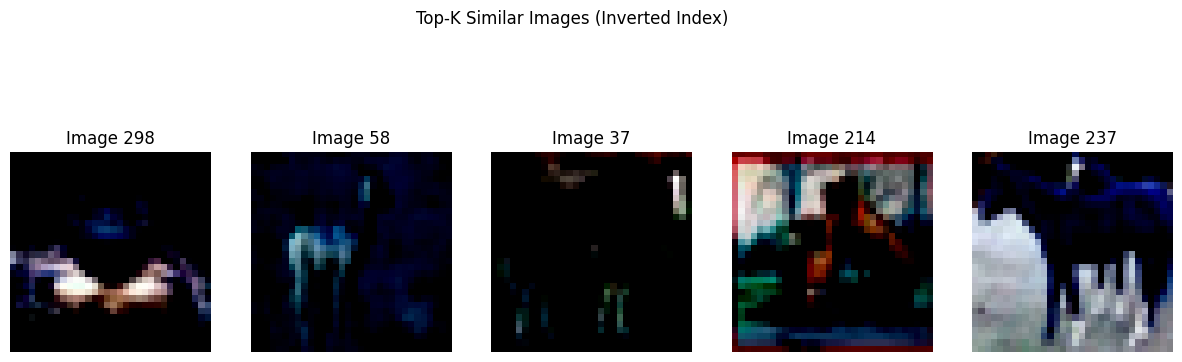

In [35]:
# Select a query image from the 'images' array
query_index = 0  # You can change this index to select a different query image
query_image = images[0]

query_image = inputs.squeeze().permute(1, 2, 0).numpy()
query_image = (query_image * 255).astype(np.uint8)
query_image = cv2.cvtColor(query_image, cv2.COLOR_RGB2BGR)

# Extract SIFT features from the query image
query_descriptors = extract_sift_features(query_image)

# Assign each query feature to its nearest visual word in the codebook
query_visual_words = assign_visual_words(query_descriptors, visual_words)

print(f"Visual words for the query image: {query_visual_words}")

# Function to retrieve top-K most similar images using the inverted index
def retrieve_top_k_inverted_index(query_visual_words, inverted_index, k=5):
    candidate_images = {}
    for word in query_visual_words:
        if word in inverted_index:
            for img_idx in inverted_index[word]:
                if img_idx not in candidate_images:
                    candidate_images[img_idx] = 0
                candidate_images[img_idx] += 1
    
    sorted_candidates = sorted(candidate_images.items(), key=lambda item: item[1], reverse=True)
    top_k_indices = [idx for idx, _ in sorted_candidates[:k]]
    return top_k_indices

# Retrieve top-K similar images using the inverted index
top_k_indices = retrieve_top_k_inverted_index(query_visual_words, inverted_index, k=5)

# Display results
def display_images(indices, title):
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 5))
    for ax, idx in zip(axes, indices):
        ax.imshow(cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB))
        ax.set_title(f"Image {idx}")
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

print("Query Image:")
plt.imshow(cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB))
plt.title(f"Query Image - Index: {query_index}")
plt.axis('off')
plt.show()

display_images(top_k_indices, "Top-K Similar Images (Inverted Index)")
